# Summary

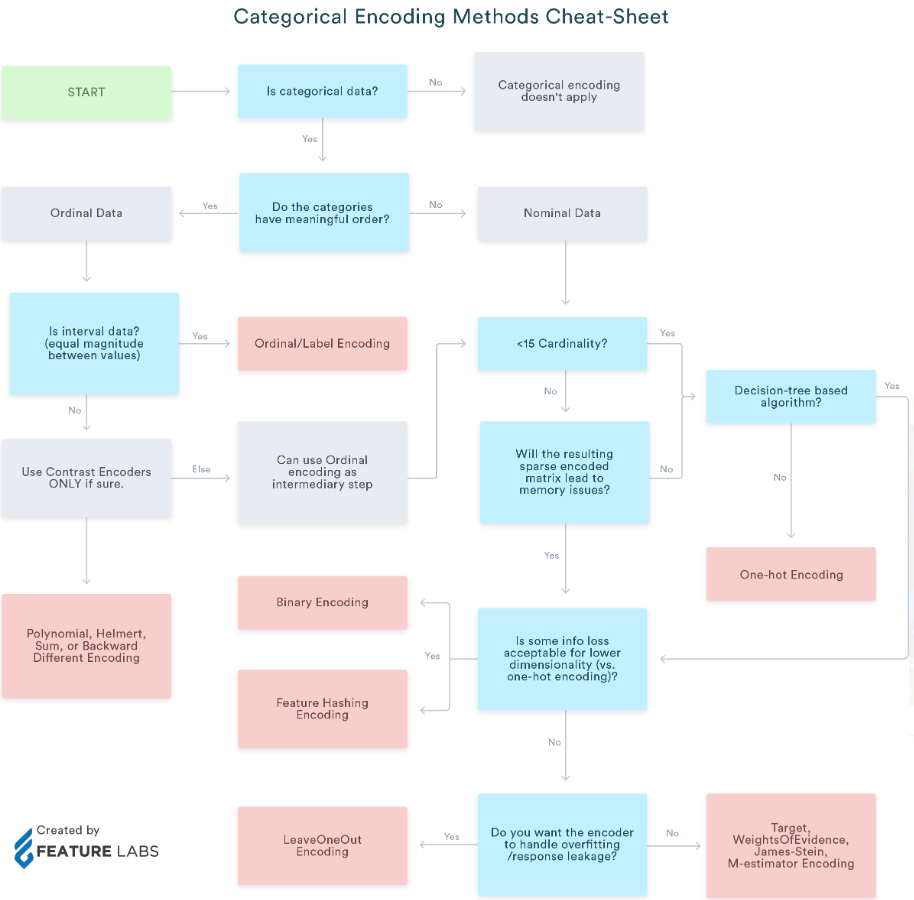

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

In [ ]:
df = pd.DataFrame({
    'temperature': ['Hot', 'Cold', 'Very Hot', 'Warm', 'Hot', 'Warm', 'Warm', 'Hot', 'Hot', 'Cold'],
    'target': [1, 1, 1, 0, 1, 0, 1, 0, 1, 1]
})

# One-Hot Encoding

- Map each category to a vector that contains 1 and 0 denoting the presence or absence of the feature.
- The number of vectors depends on the number of categories for a feature.
- This method produces a lot of columns that slows down the learning significantly if number of category is very high for the feature.

In [ ]:
# Pandas
pd.concat([
    df,
    pd.get_dummies(df['temperature'], prefix='temperature')
], axis=1)

In [ ]:
# Scikit-Learn
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(handle_unknown='error', dtype=np.int8)
pd.concat([
    df,
    pd.DataFrame(
        onehot.fit_transform(df['temperature'].values.reshape(-1, 1)).toarray(),
        columns=[f'temperature_{y}' for i,x in enumerate(onehot.categories_) for y in x]
    )
], axis=1)

# Label Encoding

- In this encoding each category is assigned a value from 1 through N (here N is the number of category for the feature.
- One major issue with this approach is there is no relation or order between these classes but algorithm might consider them as some kind of order or there is some kind of relationship.
- In below example it may look like (Cold<Hot<Very Hot<Warm….0 < 1 < 2 < 3 ), as scikit-learn sorted in alphabetical order

In [ ]:
pd.concat([
    df,
    pd.DataFrame({
        'nominal_label': LabelEncoder().fit_transform(df['temperature'])
    })
], axis=1)

# Ordinal Encoding

- Ordinal encoding is done to ensure encoding of variable retains ordinal nature of the variable.
- This encoding looks almost similar to Label Encoding but slightly different as Label encoding would not consider whether variable is ordinal or not and it will assign sequence of integers.
- If we consider in the temperature scale as the order then ordinal value should from "Cold" to "Very Hot".
- Ordinal encoding will assign values as (Cold(1) <Warm(2)<Hot(3)<”Very Hot(4)).
- Usually Ordinal Encoding is done starting from 1.

In [ ]:
pd.concat([
    df,
    pd.DataFrame({
        'ordinal_label': df['temperature'].map({
            'Cold': 1,
            'Warm': 2,
            'Hot': 3,
            'Very Hot': 4,
        })
    })
], axis=1)

# Helmert Encoding

- The mean of the dependent variable for a level is compared to the mean of the dependent variable over all previous levels.

In [ ]:
pd.concat([
    df,
    ce.HelmertEncoder(cols=['temperature'], drop_invariant=True).fit_transform(df['temperature'])
], axis=1)

# Binary Encoding

- Convert a category into a binary digits.
- Each binary digit creates one feature column.
- If there are n unique categories, then binary encoding results in only log(base 2)ⁿ features.
- In this example we have 4 feature, thus total number of binary encoded feature will be 3 features.
- Compared to One-Hot Encoding this will require less feature columns (for 100 categories One-Hot Encoding will have 100 features while for Binary encoding we will require just 7 features).

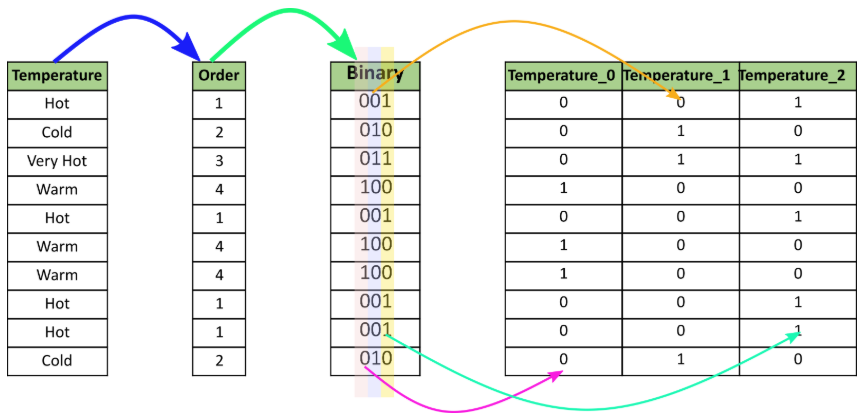

In [ ]:
pd.concat([
    df,
    ce.BinaryEncoder(cols=['temperature']).fit_transform(df['temperature'])
], axis=1)

# Frequency Encoding

- It is a way to utilize the frequency of the categories as labels.
- In the cases where the frequency is related somewhat with the target variable, it helps the model to understand and assign the weight in direct and inverse proportion, depending on the nature of the data.

In [ ]:
pd.concat([
    df,
    pd.DataFrame({
        'frequency_encode': df['temperature'].map(
            dict(df['temperature'].value_counts() / len(df))
        )
    })
], axis=1)

# Mean Encoding

- Mean encoding is similar to label encoding, except here labels are correlated directly with the target.
- Usually Mean Encoding is notorious for over-fitting, thus a regularization with cross validation or some other approach is a must in most occasion.

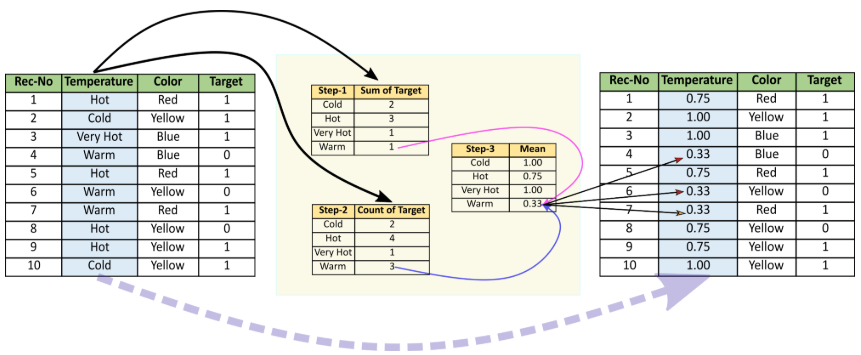

In [ ]:
pd.concat([
    df,
    pd.DataFrame({
        'mean_encode': df['temperature'].map(
            dict(df.groupby('temperature')['target'].mean())
        )
    })
], axis=1)

# Mean Encoding with Smoothing

- To overcome over-fitting
- Relying on an average value isn’t always a good idea when the number of values used in the average is low. Keep in mind that the dataset you’re training on is a sample of a larger set. This means that whatever artifacts you may find in the training set might not hold true when applied to another dataset (i.e. the test set).
- Reference: https://maxhalford.github.io/blog/target-encoding-done-the-right-way/

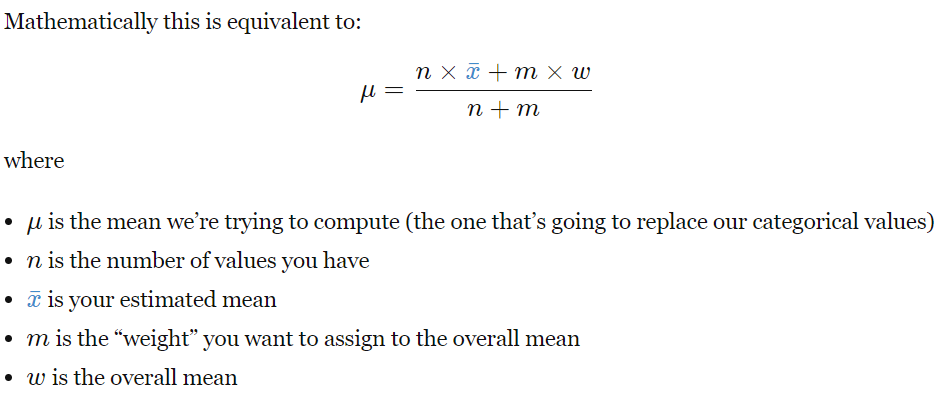

In [ ]:
agg_df        = df.groupby('temperature')['target'].agg(['count', 'mean'])
count         = agg_df['count']
estimate_mean = agg_df['mean']
weight        = 100 # 0 = Mean Encoding without smoothing
overall_mean  = df['target'].mean()

smooth_mean   = (count * estimate_mean + weight * overall_mean) / (count + weight)
pd.concat([
    df,
    pd.DataFrame({
        'mean_encode': df['temperature'].map(
            dict(smooth_mean)
        )
    })
], axis=1)

# Weight of Evidence Encoding (WoE)

- Measure the "strength" of a grouping technique to separate good and bad.
- "Strength" refers to how much the evidence supports or undermines a hypothesis.
- This method was developed primarily to build predictive model to evaluate risk of loan default in credit and financial industry.
- Reference: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

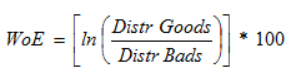

In [ ]:
woe_df = pd.DataFrame({
    'Good': df.groupby('temperature')['target'].mean()
})

# Calculate "Bad" probability, and add small value to avoid dividing by zero
woe_df['Bad'] = 1 - woe_df['Good']
woe_df['Bad'] = np.where(woe_df['Bad'] == 0, 0.000001, woe_df['Bad'])

# Calculate WoE
woe_df['WoE'] = np.log(woe_df['Good'] / woe_df['Bad'])
woe_df

In [ ]:
pd.concat([
    df,
    pd.DataFrame({
        'woe_encode': df['temperature'].map(woe_df['WoE'])
    })
], axis=1)

# Probability Ratio Encoding

- Similar to WoE but just using Good & Bad probability

In [ ]:
pr_df = pd.DataFrame({
    'Good': df.groupby('temperature')['target'].mean()
})

# Calculate "Bad" probability, and add small value to avoid dividing by zero
pr_df['Bad'] = 1 - pr_df['Good']
pr_df['Bad'] = np.where(pr_df['Bad'] == 0, 0.000001, pr_df['Bad'])

# Calculate Probability Ratio
pr_df['PR'] = pr_df['Good'] / pr_df['Bad']
pr_df

In [ ]:
pd.concat([
    df,
    pd.DataFrame({
        'pr_encode': df['temperature'].map(pr_df['PR'])
    })
], axis=1)

# Hashing

- Hashing converts categorical variables to a higher dimensional space of integers, where the distance between two vectors of categorical variables in approximately maintained the transformed numerical dimensional space.
- With Hashing, the number of dimensions will be far less than the number of dimensions with encoding like One-Hot Encoding.
- This method is very effective when cardinality of categorical is very high.
- Supported hashing methods can be checked by:
```
import hashlib
hashlib.algorithms_available
```

In [ ]:
n_components = 8
pd.concat([
    df,
    ce.HashingEncoder(cols=['temperature'], max_process=1, n_components=n_components, hash_method='md5').fit_transform(df['temperature'])
], axis=1).rename(columns={f'col_{x}': f'temperature_{x}' for x in range(n_components)})